In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score 
from rich import print #rich print allows for colored and styled output 
import numpy as np


In [2]:
# Load data
data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")
data = data.drop(columns=["ADDRESS"])

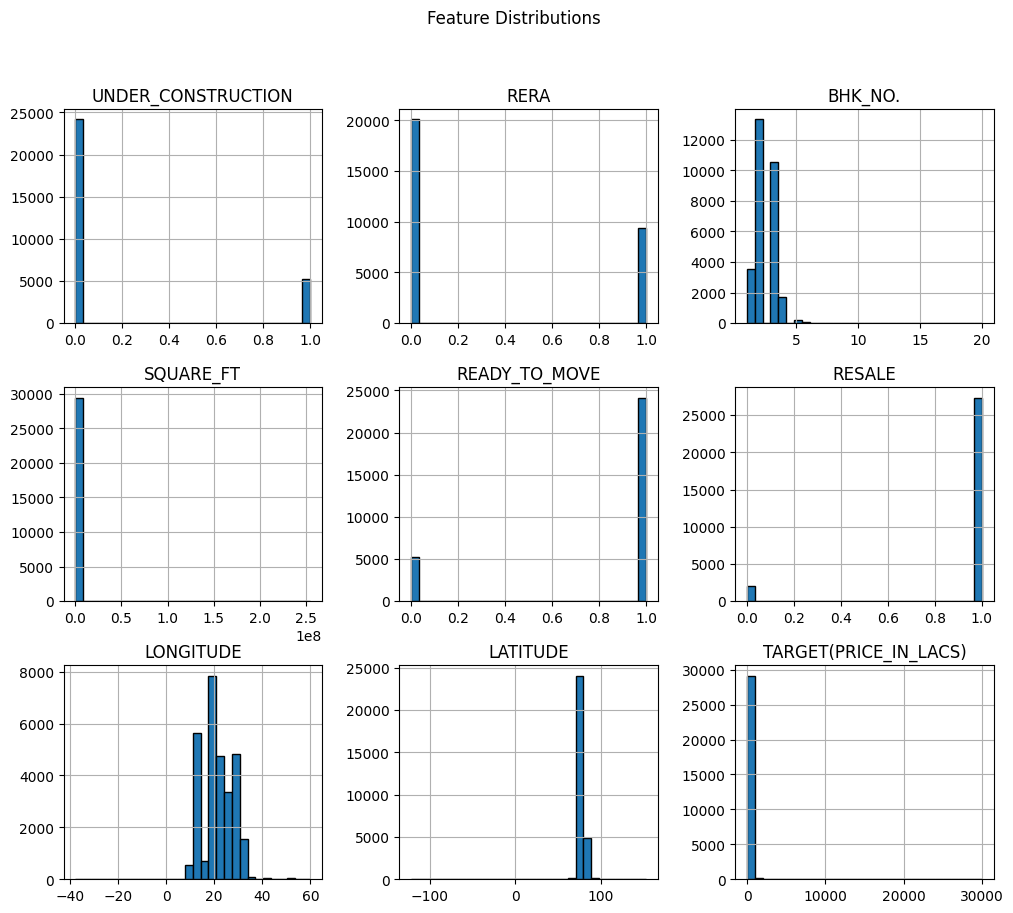

In [3]:
# Visualize dataset
data.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

In [4]:
# Define independent and dependent variables
x = data.drop("TARGET(PRICE_IN_LACS)", axis=1)

y = data["TARGET(PRICE_IN_LACS)"]


In [5]:
# Preprocessing
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


In [6]:
# Identify numeric and categorical columns
numeric_columns = x.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = x.select_dtypes(include=['object']).columns

In [7]:
# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [8]:
# Apply transformation
x_preprocessed = preprocessor.fit_transform(x)
test_preprocessed = preprocessor.transform(test_data)
# After one-hot encoding and before train/test split
x = pd.get_dummies(x, drop_first=True)

# Save feature columns
import joblib
joblib.dump(x.columns.tolist(), "model_columns.pkl")

# x_preprocessed = preprocessor.fit_transform(x)
# test_preprocessed = preprocessor.transform(test_data)

['model_columns.pkl']

In [9]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, y, test_size=0.2, random_state=16)

In [10]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(random_state=56),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=56),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=56),
    "Ridge Regression": Ridge(random_state=56)
}


In [11]:
# Try XGBoost if available
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(n_estimators=100, random_state=56)
except ImportError:
    print("XGBoost not installed. Skipping XGBoost model.")


XGBoost not installed. Skipping XGBoost model.

In [12]:
# Train and evaluate models
results = {}
best_model = None
best_r2 = float('-inf')


In [13]:
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test,y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "Explained Variance": explained_variance_score(y_test, y_pred)
    }
    
    # Track best model
    if r2 > best_r2:
        best_r2 = r2
        best_model = model

In [14]:
# Display results
for model, metrics in results.items():
    print(f"[bold green]{model}[/bold green]:")  # Make the model name bold and green
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")
    print()  # New line between models

Linear Regression:

MAE: 147.88006148177564

MSE: 430552.6024153113

RMSE: 656.1650725353426

R2 Score: 0.20106507658711048

MAPE: 1.6768929739661098

Explained Variance: 0.20126370963776874

Lasso Regression:

MAE: 147.20343446468078

MSE: 430748.5481214601

RMSE: 656.3143668406627

R2 Score: 0.20070147904558622

MAPE: 1.6747305307309353

Explained Variance: 0.2009078757519569

ElasticNet Regression:

MAE: 137.05683443433736

MSE: 456805.07874593796

RMSE: 675.8735671306713

R2 Score: 0.1523508891708738

MAPE: 1.5209602206216386

Explained Variance: 0.15262029216952178

Decision Tree:

MAE: 39.625027613844885

MSE: 131619.78006978624

RMSE: 362.7944046836806

R2 Score: 0.7557658731598077

MAPE: 0.4106438649918967

Explained Variance: 0.7557692140921326

Random Forest:

MAE: 34.42279389055791

MSE: 117433.51706108231

RMSE: 342.6857409655125

R2 Score: 0.7820899526957183

MAPE: 0.3226750382436083

Explained Variance: 0.7820942402883455

Gradient Boosting:

MAE: 45.24854806369491

MSE: 116450.13403652182

RMSE: 341.2479070068003

R2 Score: 0.7839147216949194

MAPE: 0.4827503787736273

Explained Variance: 0.783930442113995

Ridge Regression:

MAE: 147.8869164368572

MSE: 430563.1309841084

RMSE: 656.1730952912565

R2 Score: 0.2010455397378188

MAPE: 1.676913721704563

Explained Variance: 0.20124440498635165

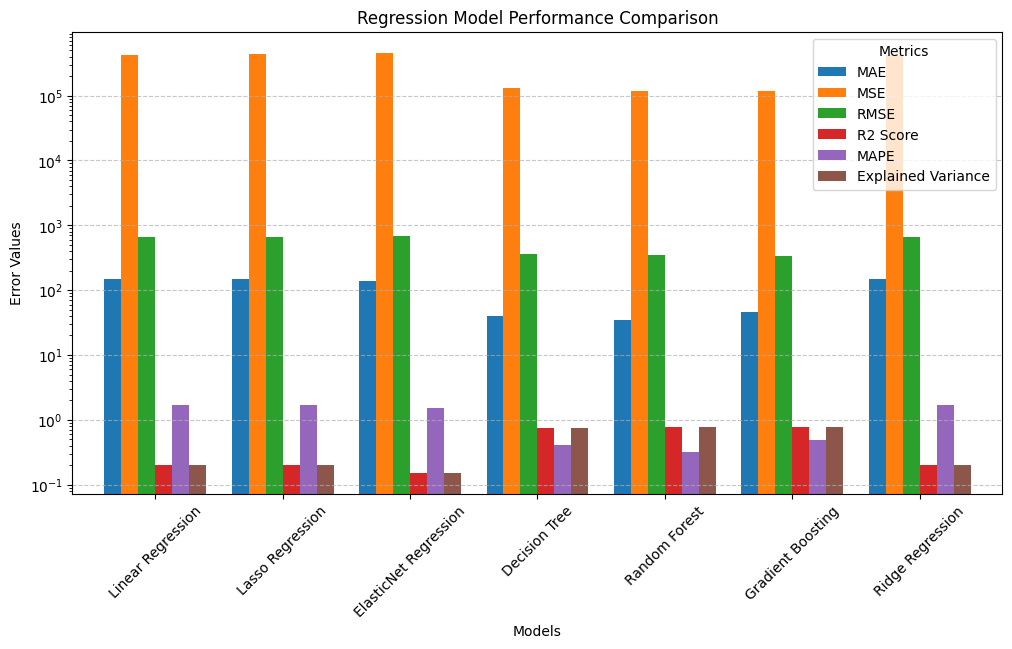

In [15]:
# Visualization of Model Performance
metrics_df = pd.DataFrame(results).T
ax = metrics_df[['MAE', 'MSE', 'RMSE', 'R2 Score', 'MAPE', 'Explained Variance']].plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title("Regression Model Performance Comparison")
plt.ylabel("Error Values")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.yscale("log")  # Use logarithmic scale to prevent dominance of high MSE values
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


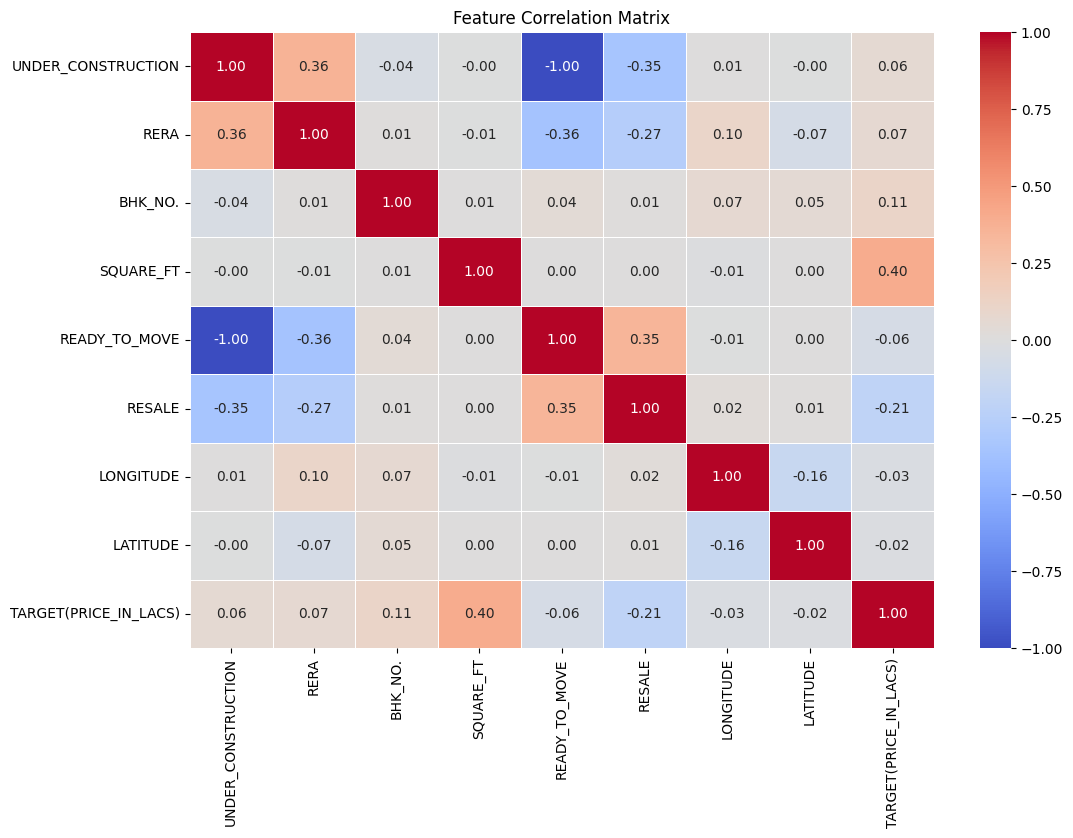

In [16]:
# Correlation Matrix Visualization
data_numeric = data.select_dtypes(include=['number'])  # Select only numerical columns
correlation_matrix = data_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

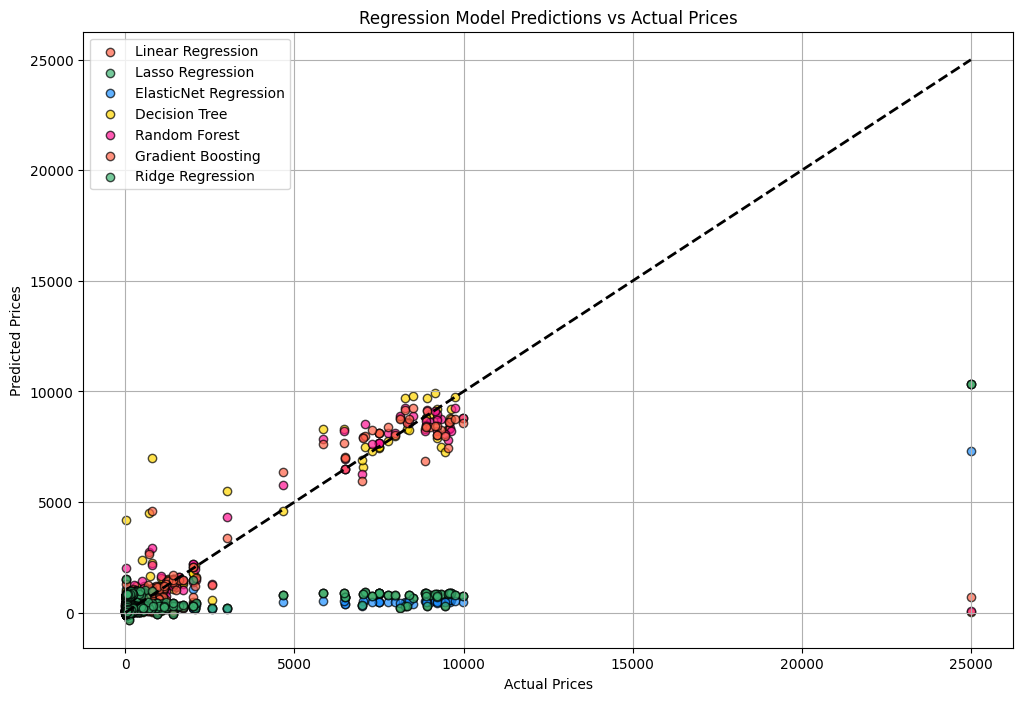

In [17]:
# Visualization for each regression model
plt.figure(figsize=(12, 8))

# Define a list of bright colors for the models
colors = ['#FF6347', '#3CB371', '#1E90FF', '#FFD700', '#FF1493']

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(x_test)
    plt.scatter(y_test, y_pred, label=name, alpha=0.7, color=colors[idx % len(colors)], edgecolors='black')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Regression Model Predictions vs Actual Prices")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Predict house prices on test dataset using best model
test_predictions = best_model.predict(test_preprocessed)

In [ ]:
# Save predictions
submission = pd.DataFrame({"Predicted Price": test_predictions})
submission.to_csv("sample_submission.csv", index=False)
print("Predictions saved to Sample_submission.csv")

Predictions saved to Sample_submission.csv

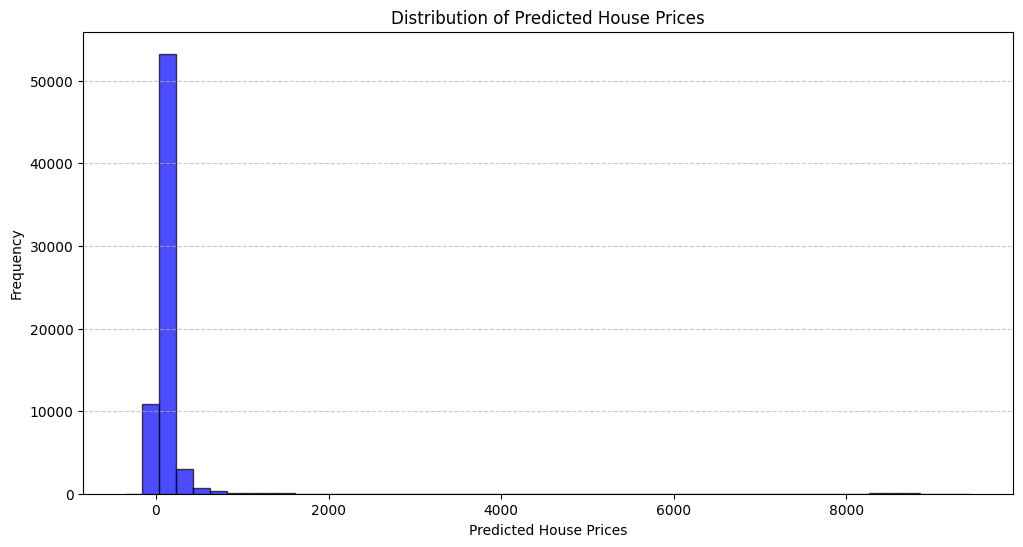

In [20]:
# Visualizing the test predictions
plt.figure(figsize=(12, 6))
plt.hist(test_predictions, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted House Prices")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted House Prices")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
import joblib
import pandas as pd

# Preprocess features
X = pd.get_dummies(x, drop_first=True)
X = X.fillna(X.mean())

# Train and save each model
for model_name, model in models.items():
    model.fit(X, y)  # ✅ Use preprocessed X
    filename = f"{model_name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, filename)
    print(f"Model '{model_name}' saved as {filename}")


Model 'Linear Regression' saved as linear_regression_model.pkl

Model 'Lasso Regression' saved as lasso_regression_model.pkl

Model 'ElasticNet Regression' saved as elasticnet_regression_model.pkl

Model 'Decision Tree' saved as decision_tree_model.pkl

Model 'Random Forest' saved as random_forest_model.pkl

Model 'Gradient Boosting' saved as gradient_boosting_model.pkl

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.39166e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model 'Ridge Regression' saved as ridge_regression_model.pkl